# Segment Anything Model (SAM) Integration

> Making use of H3 global grid indexing when working with rasters. For this example series, we focus on B04 (red), B03 (green), B02 (blue), and B08 (nir).

---
__Last Update:__ 17 JAN 2024 [Mosaic 0.3.14]

## Setup Notes

> Raster processing is memory intensize. Here are some config tips.

* This notebook was run on AWS [r5d.4xlarge](https://www.databricks.com/product/pricing/product-pricing/instance-types) instances (1-10 workers auto-scaling for up to 160 concurrent tasks).
* __Optional:__ Prior to launching, the following can be added to the cluster spark configs, adapted from this databricks [blog](https://www.databricks.com/blog/2015/05/28/tuning-java-garbage-collection-for-spark-applications.html) and these JVM tuning [docs](https://docs.oracle.com/cd/E40972_01/doc.70/e40973/cnf_jvmgc.htm#autoId2): `spark.executor.extraJavaOptions -XX:+UseG1GC -XX:+PrintFlagsFinal -XX:InitiatingHeapOccupancyPercent=35 -XX:G1HeapRegionSize=32M -XX:ParallelGCThreads=16 -XX:ConcGCThreads=4`. _This optimization is not required for this example._

## Imports + Config

In [0]:
%pip install --quiet 'databricks-mosaic<0.4,>=0.3' 
%pip install --quiet databricks-mosaic rasterio==1.3.5 gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich
%pip install --quiet torch transformers

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
spark.conf.set("spark.sql.shuffle.partitions", 512)

# -- import databricks + delta + spark functions
from delta.tables import *
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, pandas_udf, udf
from pyspark.sql.types import *
from pyspark.sql.window import Window

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- SAM imports
from PIL import Image
from rasterio.plot import reshape_as_raster, reshape_as_image
from transformers import SamModel, SamProcessor

import numpy as np
import pandas as pd
import requests
import sam_lib
import torch

# -- other imports
from datetime import datetime
from io import BytesIO
from matplotlib import pyplot
from rasterio.io import MemoryFile

import library
import os
import pathlib
import planetary_computer
import pystac_client
import rasterio
import requests
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




In [0]:
mos.__version__

Out[2]: '0.3.14'

In [0]:
%reload_ext autoreload
%autoreload 2
%reload_ext library
%reload_ext sam_lib

### Databricks Catalog + Schema

> This is for reading and writing out table(s). __Note: these should already exists after running notebook 01.__

In [0]:
# adjust to match your catalog + schema
catalog_name = "geospatial_docs"
db_name = "eo_alaska"

sql(f"""USE CATALOG {catalog_name}""")
sql(f"""USE DATABASE {db_name}""")

Out[4]: DataFrame[]

## Data + Model Load

In [0]:
%sql show tables

database,tableName,isTemporary
eo_alaska,band_b02,false
eo_alaska,band_b02_h3,false
eo_alaska,band_b02_h3_clip,false
eo_alaska,band_b02_h3_merge,false
eo_alaska,band_b02_tile,false
eo_alaska,band_b03,false
eo_alaska,band_b03_h3,false
eo_alaska,band_b03_tile,false
eo_alaska,band_b04,false
eo_alaska,band_b04_h3,false


In [0]:
b02_h3_df = spark.read.table("band_b02_h3")

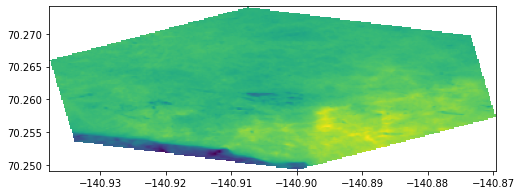

In [0]:
library.plot_raster(b02_h3_df.limit(50).collect()[0]["tile"]["tile"])

In [0]:
b02_h3_df.printSchema()

root
 |-- index_id: long (nullable = true)
 |-- item_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- band_name: string (nullable = true)
 |-- tile: struct (nullable = true)
 |    |-- index_id: long (nullable = true)
 |    |-- tile: binary (nullable = true)
 |    |-- parentPath: string (nullable = true)
 |    |-- driver: string (nullable = true)
 |-- size: long (nullable = true)
 |-- bbox: binary (nullable = true)
 |-- srid: string (nullable = true)



In [0]:
# https://huggingface.co/facebook/sam-vit-huge

def get_device():
   return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_sam_processor():
  return SamProcessor.from_pretrained("facebook/sam-vit-huge")

def load_sam_model(device=get_device()):
  return SamModel.from_pretrained("facebook/sam-vit-huge").to(device)

sam_model = load_sam_model()
sam_processor = load_sam_processor()

## Apply SAM on one of the tiles

In [0]:
tiles = (
  b02_h3_df
  .select("tile.*")
  .limit(50)
  .collect()
)

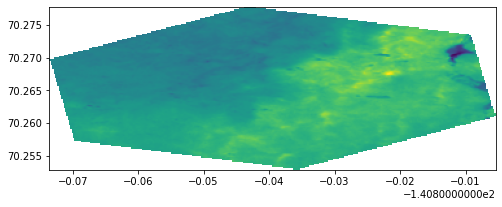

In [0]:
tile = tiles[1]["tile"]
library.plot_raster(tile)

In [0]:
def raster_to_image(tile, band_num=1):
  """
  Reshape the provided tile for PIL.
  Adapted from https://rasterio.readthedocs.io/en/stable/topics/image_processing.html
  """
  try:
    np_raster = library.to_numpy_arr(tile).astype(np.uint8)
    np_img = reshape_as_image(np_raster)
    np_img1 = np_img[:,:, band_num - 1]
    return Image.fromarray(np_img1)
  except:
    return None

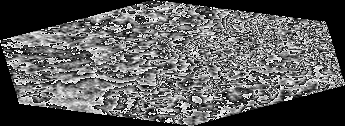

In [0]:
raw_image = raster_to_image(tile, band_num=1)
raw_image

In [0]:
def get_masks(raw_image, model=sam_model, processor=sam_processor, device=get_device()):
  inputs = processor(raw_image, return_tensors="pt").to(device)
  image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
  inputs.pop("pixel_values", None)
  inputs.update({"image_embeddings": image_embeddings})

  with torch.no_grad():
    outputs = sam_model(**inputs)

  masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
  )
  return masks
  
def get_scores(raw_image, model=sam_model, processor=sam_processor, device=get_device()):
  inputs = processor(raw_image, return_tensors="pt").to(device)
  image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
  inputs.pop("pixel_values", None)
  inputs.update({"image_embeddings": image_embeddings})

  with torch.no_grad():
    outputs = model(**inputs)

  scores = outputs.iou_scores
  return scores

In [0]:
scores = get_scores(raw_image)
masks = get_masks(raw_image)
print("scores ->", scores)
print("masks ->", masks[0][0][0])

scores -> tensor([[[0.4749, 0.4699, 0.5877]]])
masks -> tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


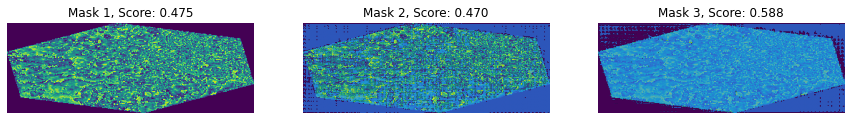

In [0]:
sam_lib.show_masks_on_image(raw_image, masks[0], scores)


## Scaling model scoring with pandas UDFs

> This is just showing a subset to give an example of the pattern. You can limit further, e.g. `limit(10)`, or can open up to the entire dataset if you like. Running SAM on the specified notebook config took about 10 minutes for 256.

In [0]:
@pandas_udf("array<double>")
def apply_sam(rasters: pd.Series) -> pd.Series:
  return rasters\
    .apply(lambda tile: raster_to_image(tile))\
    .apply(lambda image: get_scores(image).flatten().tolist())

In [0]:
(
  b02_h3_df
  .select("item_id","tile")
  .limit(256)
  .repartition(256, "tile")
  .withColumn("model_result", apply_sam(F.col("tile.tile")))
  .display()
)

item_id,tile,model_result
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031186471616511, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.4300404191017151, 0.4358000159263611, 0.6175134778022766)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031187360808959, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.42843425273895264, 0.41022831201553345, 0.6454695463180542)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031188367441919, SUkqAAgAAAASAAABAwABAAAAWAEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.5468724966049194, 0.6990165710449219, 0.8356167078018188)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031200195379199, SUkqAAgAAAASAAABAwABAAAAWwEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.46025514602661133, 0.4958462417125702, 0.6948965787887573)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031185834082303, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.4593520760536194, 0.5747880935668945, 0.6538804769515991)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031184726786047, SUkqAAgAAAASAAABAwABAAAAXQEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.4198278784751892, 0.43575239181518555, 0.7103714942932129)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031186891046911, SUkqAAgAAAASAAABAwABAAAAWAEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.45860159397125244, 0.4934611916542053, 0.729158878326416)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031186941378559, SUkqAAgAAAASAAABAwABAAAAWAEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)","List(0.42485758662223816, 0.47579535841941833, 0.5085985660552979)"
S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,"List(608031190934355967,